In [16]:
%%capture
!pip install wandb

In [17]:
import os, shutil, time, itertools, random
import wandb, logging

import numpy as np
import pandas as pd
import matplotlib as mpl, matplotlib.pyplot as plt
from enum import Enum

import torch
import torch.nn as nn, torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [18]:
# Utility functions

# Wrap an element into a tuple
def wrap(x): return x if isinstance(x, tuple) else (x,)

# Unwrap a tuple if it contains only one element
def unwrap(x): return x if len(x) > 1 else x[0]

In [19]:
# Constants
PAD_IDX = 0
DATASET_BASE_PATH = './data'
PLOTS_PATH = './plots'

# Dataset

In [20]:
class ATISDataset(Dataset):
  def __init__(self, split, vocab):
    if split not in ['train', 'valid', 'test']:
      raise ValueError(f'split must be either "train",  "valid", "test". "{split}" given')

    # Load dataset in local storage
    if not os.path.exists(DATASET_BASE_PATH):
      from google.colab import drive
      print('Copying dataset from drive to local storage...')
      os.makedirs(DATASET_BASE_PATH)
      drive.mount('/content/gdrive')
      shutil.copy('/content/gdrive/My Drive/NLU/data/atis.zip', f'{DATASET_BASE_PATH}/atis.zip')
      shutil.copy('/content/gdrive/My Drive/NLU/data/pretrained_embeddings.zip', f'{DATASET_BASE_PATH}/pretrained_embeddings.zip')
      shutil.copy('/content/gdrive/My Drive/NLU/data/conlleval.pl', f'{DATASET_BASE_PATH}/conlleval.pl')
      shutil.unpack_archive(f'{DATASET_BASE_PATH}/atis.zip', f'{DATASET_BASE_PATH}/atis')
      shutil.unpack_archive(f'{DATASET_BASE_PATH}/pretrained_embeddings.zip', f'{DATASET_BASE_PATH}/pretrained_embeddings')
      print('Done')

    # Set params 
    self.split = split
    self.vocab = vocab

    # Load and parse the dataset
    self.data = [[]]
    with open(f'{DATASET_BASE_PATH}/atis/{split}') as file:
      for line in file:
        line = line.strip()
        if line != '':
          word, concept = line.split('   ')
          self.vocab.add_word(word)
          self.vocab.add_concept(concept)
          self.data[-1].append((self.vocab.word2idx[word], self.vocab.concept2idx[concept]))
        else:
          self.data.append([]) # New sentence  
    self.data = [s for s in self.data if len(s) > 0]
    
    # Convert data to tensors
    self.data = [list(zip(*s)) for s in self.data]
    self.data = [(torch.tensor(s[0]), torch.tensor(s[1])) for s in self.data]

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]


# Helper class to sync words and concepts representations (indexes) of train, validation and test sets
class VocabConcepts():
  def __init__(self, padding_idx):
    # Note: padding_idx is used to identify the padding values
    self.padding_idx = padding_idx
    self.word2idx, self.idx2word = {}, {}
    self.concept2idx, self.idx2concept = {}, {}
    self.concepts_types = set()
    # Add idx=0 as PAD_IDX for compatibility when computing accuracy and f1
    self.idx2concept[0] = 'O'
  
  def add_word(self, word):
    if word not in self.word2idx:
      idx = len(self.word2idx) + (self.padding_idx+1)
      self.word2idx[word] = idx
      self.idx2word[idx] = word

  def add_concept(self, concept):
    if concept not in self.concept2idx:
      idx = len(self.concept2idx) + (self.padding_idx+1)
      self.concept2idx[concept] = idx
      self.idx2concept[idx] = concept
      split = concept.split('-')
      if len(split) > 1:
        self.concepts_types.add(split[1])

  @property
  def words_count(self): return len(self.word2idx)

  @property
  def concepts_count(self): return len(self.concept2idx)

In [21]:
def get_data(batch_size, return_datasets=False):
  # Load data
  vocab = VocabConcepts(padding_idx=PAD_IDX)
  train_data = ATISDataset('train', vocab)
  val_data = ATISDataset('valid', vocab)
  test_data = ATISDataset('test', vocab)
  
  if return_datasets: 
    return vocab, train_data, val_data, test_data

  # Collate function: add sentence padding to batches
  def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=PAD_IDX)
    targets = pad_sequence(targets, batch_first=True, padding_value=PAD_IDX)
    return inputs, targets

  # Init dataloaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size, collate_fn=collate_fn, pin_memory=True, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size, collate_fn=collate_fn, pin_memory=True, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size, collate_fn=collate_fn, pin_memory=True, shuffle=False)

  return vocab, train_loader, val_loader, test_loader

# Data analysis

Dataset info:
 - Min sentence length: 1 words
 - Avg sentence length: 11 words
 - Max sentence length: 46 words

Missing tags for each split:
 - test, count=14: stoploc.state_code, today_relative, return_date.day_number, arrive_time.period_mod, return_date.month_name, arrive_date.today_relative, return_time.period_of_day, return_time.period_mod, stoploc.airport_name, time, day_number, month_name, time_relative, return_date.today_relative
 - train, count=8: day_number, month_name, time_relative, compartment, booking_class, flight, return_date.today_relative, stoploc.airport_code
 - valid, count=9: stoploc.state_code, state_name, arrive_date.today_relative, return_date.day_name, stoploc.airport_name, compartment, booking_class, flight, stoploc.airport_code


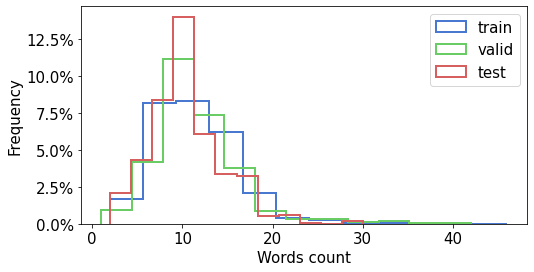

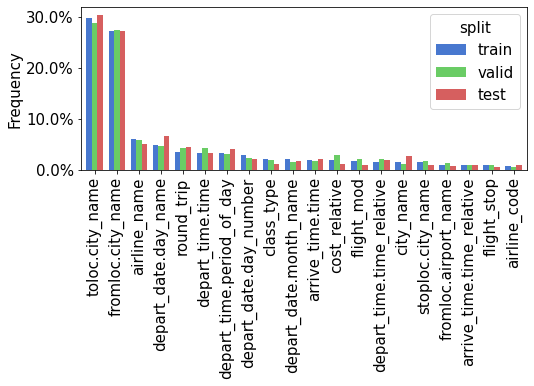

In [22]:
plt.style.use('seaborn-muted')
plt.rcParams['font.size'] = '15'
os.makedirs(PLOTS_PATH, exist_ok=True)

# Dataset analysis
vocab, train, val, test = get_data(1, return_datasets=True)
df = []
for data_split in [train, val, test]:
  for sentence_id, (input, target) in enumerate(data_split.data):
    for i, (w, c) in enumerate(zip(input, target)):
      c = vocab.idx2concept[c.item()].split('-') 
      iob, tag = c if len(c) > 1 else (c[0], None)
      df.append((sentence_id, i, vocab.idx2word[w.item()], iob, tag , data_split.split))
df = pd.DataFrame(df, columns=['sentence_idx', 'word_idx', 'word', 'iob', 'tag', 'split'])

tags_freq = df.groupby(['tag', 'split']).word.count().to_frame().reset_index().pivot(index='tag', columns='split',values='word').fillna(0)
tags_freq = tags_freq.sort_values(by='train', ascending=False)[['train', 'valid', 'test']]
sent_len = df.groupby(['split', 'sentence_idx']).word.count()

# General info
print('Dataset info:')
print(f' - Min sentence length: {sent_len.min():.0f} words')
print(f' - Avg sentence length: {sent_len.mean():.0f} words')
print(f' - Max sentence length: {sent_len.max():.0f} words')

# Missing tags
print('\nMissing tags for each split:')
for row in tags_freq.pipe(pd.melt, ignore_index=False).pipe(lambda x : x[x.value==0]).groupby('split').apply(lambda x: list(x.index)).reset_index().itertuples():
  print(f' - {row.split}, count={len(row._2)}: {", ".join(row._2)}')

# Sentences lengths
for split in ['train', 'valid', 'test']:
  ax = sent_len.loc[split, :].rename(split).plot.hist(bins=12, density=True, figsize=(8, 4), legend=True, lw=2, histtype='step')
ax.set_xlabel('Words count')
ax.set_ylabel('Frequency')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
plt.savefig(f'{PLOTS_PATH}/sent_len.png', bbox_inches='tight', dpi=200)

# Tags frequency
ax=tags_freq[:20].pipe(lambda x: x/x.sum(axis=0)).plot.bar(figsize=(8, 3), width=.75) # Normalized frequencies
ax.set_xlabel('')
ax.set_ylabel('Frequency')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
plt.savefig(f'{PLOTS_PATH}/tag_freq.png', bbox_inches='tight', dpi=200)

# Show all
plt.show()

# Model

In [23]:
class Seq2Seq(nn.Module):
  def __init__(self, cell_type, vocab, pretrained_embedding, output_size, hidden_size, num_layers, attention_type, bidirectional, dropout_prob, embedding_max_norm, teacher_forcing_rate):
    super(Seq2Seq, self).__init__()
    self.vocab_size = vocab.words_count+1 # Include 1 value for padding (as PAD_IDX)
    self.output_size = output_size+1 # Include 1 value for padding (as PAD_IDX)
    self.hidden_size = hidden_size
    self.attention_type = attention_type
    self.bidirectional = bidirectional
    self.num_directions = 1 if not bidirectional else 2
    self.num_layers = num_layers
    self.teacher_forcing_rate = teacher_forcing_rate
    
    # Init encoder embedding 
    if pretrained_embedding is None: # NEw empty embedding
      self.encoder_embedding = nn.Embedding(self.vocab_size, 300, max_norm=embedding_max_norm, padding_idx=PAD_IDX) 
    elif pretrained_embedding in [embedding.GloVe, embedding.Word2Vec]: # Load pretrained embedding
      embeddings = pd.read_pickle(f'{DATASET_BASE_PATH}/pretrained_embeddings/{pretrained_embedding.value}.pickle')
      embedding_dim = len(embeddings.iloc[0].embedding)
      weigths = [None]*self.vocab_size
      weigths[0] = np.zeros(embedding_dim) # First embedding is for PAD_IDX, set to all zeros
      for word, idx in vocab.word2idx.items():
        if word in embeddings.index: weigths[idx] = embeddings.loc[word].embedding
        else: weigths[idx] = np.random.normal(size=embedding_dim) # Same initialization of pytorch's Embedding
      self.encoder_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weigths), max_norm=embedding_max_norm, padding_idx=PAD_IDX, freeze=False)
    else:
      raise ValueError(f'Embedding type "{pretrained_embedding}" not supported')
    self.encoder_embedding_size = self.encoder_embedding.embedding_dim

    # Init decoder embedding. Add another value for "start" token
    self.decoder_embedding = nn.Embedding(self.output_size+1, self.output_size//2, max_norm=embedding_max_norm, padding_idx=PAD_IDX) 
    self.decoder_embedding_size = self.decoder_embedding.embedding_dim
    
    # Init encoder/decoder layers
    hs = self.num_directions # Adjust hidden_size, since a bidirectional layer will have 2*hidden_size units
    decoder_input_size = self.decoder_embedding_size + (hidden_size if attention_type is attention.Concat else 0) # Decoder input size according to the attention model used
    if cell_type in [nn.RNN, nn.LSTM, nn.GRU]:
      self.encoder_layer = cell_type(input_size=self.encoder_embedding_size, hidden_size=hidden_size//hs, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
      self.decoder_layer = cell_type(input_size=decoder_input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    else:
      raise ValueError(f'Cell type "{cell_type}" not supported')

    # Init attention layers
    self.W_a = nn.Linear(hidden_size, hidden_size, bias=False)  # Concat attn, decoder weights
    self.U_a = nn.Linear(hidden_size, hidden_size, bias=False)  # Concat attn, encoder weights
    self.v_a = nn.Linear(hidden_size, 1, bias=False)            # Concat attn, combine weights
    self.W_s = nn.Linear(hidden_size*2, hidden_size, bias=False) # Dot attn weights

    # Init fully connected layers
    self.bn = nn.BatchNorm2d(1)
    self.dropout = nn.Dropout(dropout_prob)
    self.classifier = nn.Linear(hidden_size, self.output_size)


  def encoder(self, x):
    x = self.encoder_embedding(x)
    x = self.dropout(x)
    out, h = self.encoder_layer(x) # Initial hidden state to zeros
    return out, h


  def decoder(self, x, h, len, H):
    x = self.decoder_embedding(x)
    x = self.dropout(x)
    # Apply attention and decoder
    out, h, attn = self.attention(x, h, len, H)
    # Apply final classifier
    #out = self.bn(out.unsqueeze(1)).squeeze(1)
    out = self.dropout(out)
    out = self.classifier(out)
    return out, h, attn


  def attention(self, x, h, len, H):
    if self.attention_type is None: # No attention
      (out, h), align_scores = self.decoder_layer(x, h), None
    elif self.attention_type is attention.Concat: # Concat (Bahdanau)
      h_t = h if not isinstance(h, tuple) else h[0]                          # Compatibility with LSTM layers, use only the hidden state
      h_t = h_t.view(self.num_layers, -1, 1, self.hidden_size)[-1]           # Get hidden state of the last layer, in case of multilayered network. Final output will be (batch, 1, hidden_size)
      align_scores = torch.tanh(self.W_a(h_t) + self.U_a(H))                 # Compute alignment scores
      align_scores = F.softmax(self.v_a(align_scores), dim=1).transpose(1,2) # Apply softmax to computed scores
      context = align_scores.bmm(H)       # Generate new context vector by multiplying the alignment scores with the hidden states from the encoder
      x = torch.cat([x, context], dim=2)  # The final input to the RNN is composed by [embedding, context]
      x = self.dropout(x)
      out, h = self.decoder_layer(x, h)
    elif self.attention_type is attention.Dot: # Dot (Luong)
      x, h = self.decoder_layer(x, h)
      h_t = h if not isinstance(h, tuple) else h[0]
      h_t = h_t.view(self.num_layers, -1, 1, self.hidden_size)[-1]
      align_scores = F.softmax(h_t.bmm(H.transpose(1,2)), dim=2) # Dot product
      context = align_scores.bmm(H)
      x = torch.cat([context, x], dim=2)
      out = torch.tanh(self.W_s(x))
    elif self.attention_type is attention.Local: # Local (Luong)
      x, h = self.decoder_layer(x, h)
      h_t = h if not isinstance(h, tuple) else h[0]
      h_t = h_t.view(self.num_layers, -1, 1, self.hidden_size)[-1]
      p = len * torch.sigmoid(self.v_a(torch.tanh(self.W_a(h_t)))).view(-1)
      align_scores = F.softmax(h_t.bmm(H.transpose(1,2)), dim=2)
      s = torch.arange(0, len.max(), device=device)  # Position of each hidden state of the encoder
      s = s.unsqueeze(0).repeat_interleave(p.shape[0], dim=0)
      p = p.unsqueeze(1).repeat_interleave(len.max(), dim=1)
      D = 3 # Windows size (empirically selected)
      align_scores = align_scores * torch.exp(-(((s-p)**2)/(2*((D/2)**2)))).unsqueeze(1) # Gaussian weightening
      context = align_scores.bmm(H)
      x = torch.cat([context, x], dim=2)
      out = torch.tanh(self.W_s(x))
    else:
      raise ValueError(f'Attention type "{self.attention_type}" not supported')
    return out, h, align_scores


  def forward(self, x, targets=None, beam_width=1):
    (batch_size, batch_sentence_len), out_size = x.shape, self.output_size
    device = x.device
    tfr = self.teacher_forcing_rate if self.training and targets is not None else 0  # Apply teacher forcing only during training
    beam_width = beam_width if not self.training else 1 # Apply beam search only during testing

    # Get length of each sentence based on the value of PAD_IDX
    sentence_lengths = x.eq(PAD_IDX).type(torch.int8).argmax(axis=1)
    sentence_lengths[x[:,-1] != PAD_IDX] = batch_sentence_len

    # Encoder
    e_out, e_h = self.encoder(x)
    H = e_out 

    # Transform the bidirectional final hidden state of the encoder to an unidirectional hidden state for the decoder, by concatenation
    if self.bidirectional:
      e_h = unwrap(tuple([c.transpose(0,1).reshape(batch_size, -1, self.hidden_size).transpose(0,1).contiguous() for c in wrap(e_h)])) # Use wrap/unwrap to support multiple hidden outputs, e.g. when using LSTM
   
    # Decoder
    d_x = torch.full((batch_size, 1), out_size, device=device) # Use a special idx to represent the <start> token given as initial input to the decoder
    d_h = e_h
    scores = torch.zeros((batch_size, 1), device=device)
    results, result_indexes, result_attns = torch.empty((batch_size*beam_width, 0, out_size), device=device), torch.empty((batch_size*beam_width, 0), device=device, dtype=torch.int), torch.empty((batch_size*beam_width, 0, batch_sentence_len), device=device)
    pos_idx = (torch.arange(batch_size, device=device)*beam_width).reshape(-1, 1)

    # Process each word in each sentence separately
    for i in range(batch_sentence_len): 
      # Apply decoder layer
      d_out, d_h, d_attn = self.decoder(d_x, d_h, sentence_lengths, H)
      
      # Repeat values in the batch to create #beam_width candidates for each sample
      if i == 0: 
        d_h = unwrap(tuple([c.repeat_interleave(beam_width, dim=1) for c in wrap(d_h)]))
        sentence_lengths = sentence_lengths.repeat_interleave(beam_width, dim=0)
        H = H.repeat_interleave(beam_width, dim=0) 
    
      # Compute candidates for beam search
      scores = scores + F.log_softmax(d_out.squeeze(1), dim=1)  # Apply softmax to output to obtain probabilities, and combine with previous scores. Use the log to avoid numerical instability with long sequences
      scores = scores.reshape(batch_size, -1)                   # Re-arrange results as (batch, out * beam_width)
      scores, idx = scores.topk(beam_width, dim=1)              # Extract #beam_width best condidates
      scores = scores.reshape(batch_size*beam_width, 1)
      if i == 0: selected_idx = pos_idx.expand_as(idx).reshape(batch_size*beam_width)                 # Inital selected_idx. Since it is used only to filter d_h and d_out, at the beginning simply select the inital d_h and d_out values from the encoder
      else: selected_idx = (idx // out_size + pos_idx.expand_as(idx)).reshape(batch_size*beam_width)  # Compute the indexes of the selected candidates in order to filter over d_h and d_out and obtain the new values for the next iteration
      d_x = (idx % out_size).reshape(batch_size*beam_width, 1) # Keep indexes in the output range to obtain the next input
      d_h = unwrap(tuple([c.index_select(1, selected_idx) for c in wrap(d_h)]))
      
      # Save current results, both for network outputs and labels
      if i == 0: 
        d_out = d_out.repeat_interleave(beam_width, 0)
        d_attn = d_attn.repeat_interleave(beam_width, 0) if d_attn is not None else None
      results = torch.cat([results, d_out], dim=1)
      results = results.index_select(0, selected_idx)
      result_indexes = result_indexes.index_select(0, selected_idx) # Note: in this case first the previous results are filtered, and then the new d_x are concatenated, since d_x has already been filtered 
      result_indexes = torch.cat([result_indexes, d_x], dim=1)
      if d_attn is not None:
        result_attns = torch.cat([result_attns, d_attn], dim=1)
        result_attns = result_attns.index_select(0, selected_idx)

      # Apply teacher forcing during training
      if self.training and torch.rand(1).item() < tfr:
        d_x = targets[:,i].unsqueeze(1)
      
    # Select the best candidate found by beam search as final output
    _, idx = scores.reshape(batch_size, -1).topk(1, dim=1)
    selected_idx = (idx + pos_idx).squeeze(1)
    out = results.index_select(0, selected_idx) 
    labels = result_indexes.index_select(0, selected_idx)
    attn = result_attns.index_select(0, selected_idx)
    return out, labels, attn

In [24]:
# Pre-trained embedding types
class embedding(Enum):
  GloVe = 'glove'
  Word2Vec = 'word2vec'

# Attention types
class attention(Enum):
  Concat = 1
  Dot = 2
  Local = 3

# Training

In [25]:
# Adapted from conlleval.pl
def conlleval(results):
  def parse_iob(x): return tuple(x.split('-')) if x!='O' else (x, None)
  def is_boc(iob, lbl, prev_iob, prev_lbl): return (iob=='B' or (iob=='I' and prev_iob=='O')) or (lbl!=prev_lbl and iob!='O') # Is beginning of chunck 
  def is_eoc(iob, lbl, prev_iob, prev_lbl): return (iob in ['B', 'O'] and prev_iob in ['B', 'I']) or (lbl!=prev_lbl and iob!='O') # Is end of chunck 
  accuracy, correct, found_targets, found_predicted, word_count = 0, 0, 0, 0, 0
  for sentence in results:
    prev_t, prev_p = ('O', None), ('O', None)
    in_correct = False
    for _, t, p in sentence:
      t, p = parse_iob(t), parse_iob(p)
      t_b, p_b = is_boc(t[0], t[1], prev_t[0], prev_t[1]), is_boc(p[0], p[1], prev_p[0], prev_p[1])
      t_e, p_e = is_eoc(t[0], t[1], prev_t[0], prev_t[1]), is_eoc(p[0], p[1], prev_p[0], prev_p[1])
      if in_correct:
        if t_e and p_e and prev_t[1]==prev_p[1]:
          in_correct = False
          correct += 1
        elif t_e!=p_e or t[1]!=p[1]: in_correct = False
      if t_b and p_b and t[1]==p[1]: in_correct = True
      if t_b: found_targets += 1
      if p_b: found_predicted += 1
      word_count += 1
      if t==p: accuracy += 1
      prev_t, prev_p = t, p
    if in_correct: correct += 1
  accuracy = accuracy/word_count
  recall = correct/found_targets if found_targets>0 else 0
  precision = correct/found_predicted if found_predicted>0 else 1
  f1 = (2 * precision * recall) / (precision + recall) if precision+recall>0 else 0
  return accuracy, f1

In [26]:
def train_evaluate(train, model, data_loader, vocab, loss_function, optimizer, device, beam_width=1, write_results=None):
  if train: model.train()
  else: model.eval()

  labels = list(vocab.idx2concept.keys())
  num_samples, num_words = 0, 0
  loss_sum, f1_sum, acc_sum = 0, 0, 0
  results = []
  with torch.set_grad_enabled(train):
    for batch_idx, (inputs, targets) in enumerate(data_loader):

      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass 
      outputs, predicted_labels, _ = model(inputs, targets, beam_width)
      outputs = outputs.transpose(1, 2) # Invert two dimensions to go from [N, d, C] to [N, C, d] to apply CrossEntropyLoss, where d is the number of words in the sample

      # Compute loss
      loss = loss_function(outputs, targets)
      
      # Backward pass
      if train:
        loss.backward() 
        optimizer.step() # Update parameters
        optimizer.zero_grad() # Resets the gradients

      # Compute results
      num_samples += inputs.shape[0]
      loss_sum += loss.item() * inputs.shape[0]
      for sent, trues, preds in zip(inputs, targets, predicted_labels):
        sent, trues, preds = sent[sent!=PAD_IDX], trues[sent!=PAD_IDX], preds[sent!=PAD_IDX] # Remove padding values
        results.append([(vocab.idx2word[w.item()], vocab.idx2concept[t.item()], vocab.idx2concept[p.item()]) for w, t, p in zip(sent, trues, preds)])
  
  # Return results
  loss = loss_sum/num_samples
  accuracy, f1 = conlleval(results)

  # Save results in the specified file, to be used with conlleval script
  if write_results is not None:
    os.makedirs(os.path.dirname(write_results), exist_ok=True)
    with open(write_results, 'w') as file:
      for sentence in results:
        for word, target, predicted in sentence:
          file.write(f'{word} {target} {predicted}\n')
        file.write(f'\n')
  return loss, f1, accuracy

def train(model, data_loader, vocab, loss_function, optimizer, device): return train_evaluate(True, model, data_loader, vocab, loss_function, optimizer, device, 1, None)
def evaluate(model, data_loader, vocab, loss_function, device, beam_width=1, write_results=None): return train_evaluate(False, model, data_loader, vocab, loss_function, None, device, beam_width, write_results)

In [27]:
def main(epochs, batch_size, model_params, optimizer_params, device, disable_wandb, wandb_group=None):
  print(f'Running on device: {device}\n')

  # Instantiate dataloaders
  vocab, train_loader, val_loader, test_loader = get_data(batch_size)
  print(f'Train samples: {len(train_loader.dataset)}\nValid samples: {len(val_loader.dataset)}\nTest samples: {len(test_loader.dataset)}\n')
  
  # Instantiate model
  words_count, concepts_count = vocab.words_count, vocab.concepts_count  
  model = Seq2Seq(vocab=vocab, output_size=concepts_count, **model_params).to(device)
  print(f'Vocabolary size: {words_count}\nConcepts count: {concepts_count} (with {len(vocab.concepts_types)} types)\nEncoder embedding size: {model.encoder_embedding_size}\nDecoder embedding size: {model.decoder_embedding_size}\n')

  # Instantiate loss function
  loss_function = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

  # Instantiate optimizer
  optimizer = torch.optim.Adam(model.parameters(), **optimizer_params)

  # Init logger
  wandb_config = dict(epochs=epochs, batch_size=batch_size, encoder_embedding_size=model.encoder_embedding_size, decoder_embedding_size=model.decoder_embedding_size, **model_params, **optimizer_params)
  wandb_config = {k:v.__name__ if isinstance(v, type) else v.name if isinstance(v, Enum) else v for k, v in wandb_config.items()} # Replace classes with their names
  run = wandb.init(project='nlu', reinit=True, group=wandb_group, config=wandb_config, mode='online' if not disable_wandb else 'disabled')
  run.watch(model, log='all', log_freq=50)
  def log_epoch(kind, epoch, loss, f1, accuracy):
    print(f' - {kind:<5} loss: {loss:.6f}, accuracy: {accuracy*100:.2f}%, f1: {f1*100:.2f}')
    if epoch is not None or kind.startswith('test'): 
      wandb.log({kind: {'loss': loss, 'f1': f1, 'accuracy': accuracy}})

  # Start training
  for e in range(1, epochs+1):
    print(f'Epoch {e}', end='')
    start = time.time()
    train_loss, train_f1, train_acc = train(model, train_loader, vocab, loss_function, optimizer, device)
    val_loss, val_f1, val_acc = evaluate(model, val_loader, vocab, loss_function, device)
    print(f' ({time.time() - start:.2f}s):')
    log_epoch('train', e, train_loss, train_f1, train_acc)
    log_epoch('valid', e, val_loss, val_f1, val_acc)
    print(f'----------------------------------------------------')

  # Report final performances with test set
  results_report = './results/test_results.txt'
  print(f'\nFinal results:')
  log_epoch('train', None, train_loss, train_f1, train_acc)
  log_epoch('valid', None, val_loss, val_f1, val_acc)
  for beam_width in [1, 2, 3, 4, 8, 16, 32]:
    test_loss, test_f1, test_acc = evaluate(model, test_loader, vocab, loss_function, device, beam_width=beam_width, write_results=results_report)
    log_epoch(f'test_bw{beam_width}', None, test_loss, test_f1, test_acc)


  # Run conlleval script on test results
  print(f'\nConlleval evaluation over test set (from conlleval.pl):')
  !perl  {DATASET_BASE_PATH}/conlleval.pl < {results_report} | head -n2

  # Terminate logger
  run.finish()

  return vocab, model

# Run experiments

In [28]:
def get_permutations(d):
  d = {k: get_permutations(v) if isinstance(v, dict) else v for k,v in d.items()}
  keys, values = zip(*d.items())
  return [dict(zip(keys, v)) for v in itertools.product(*values)]

# Hyper-parameters tuning
def start_sweep(name, device, repetition_count):
  
  # Possible hyper-params combinations
  parameters=dict(
    epochs=[30],
    batch_size=[8, 16, 32, 64],
    model_params=dict(
      cell_type=[nn.RNN, nn.GRU, nn.LSTM],
      pretrained_embedding=[None, embedding.Word2Vec],
      hidden_size=[128, 256], 
      num_layers=[1, 2],
      attention_type=[None, attention.Concat, attention.Dot, attention.Local],
      bidirectional=[True, False],
      dropout_prob=[0.1, 0.3, 0.5],
      embedding_max_norm=[2, 4, 8],
      teacher_forcing_rate=[0.5],
    ),
    optimizer_params=dict(
      lr=[0.001, 0.002, 0.005],
      weight_decay=[0, 0.0001]
    )
  )

  parameters = get_permutations(parameters)
  random.shuffle(parameters)
  for i, params in enumerate(parameters):
    for j in range(repetition_count): # Run each experiment multiple times 
      print(f'Running experiment {i+1} of {len(parameters)} (run {j+1}/{repetition_count}) from {name}\n')
      main(**params, device=device, disable_wandb=False, wandb_group=name)

In [29]:
logging.getLogger('wandb').setLevel(logging.ERROR) # Disable wandb info logs
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#torch.manual_seed(0) # Uncomment to enable reproducible results

# Start a new hyper-parameters sweep, trying diffirent params combinations. Each combination is executed 15 times.
#start_sweep('sweep4', device, 15) 

# Train and evaluate the model
vocab, model = main(
  epochs=30, 
  batch_size=8, 
  model_params=dict(
    cell_type=nn.LSTM,                        # nn.RNN, nn.LSTM, nn.GRU
    pretrained_embedding=embedding.Word2Vec,  # None, embedding.GloVe, embedding.Word2Vec
    hidden_size=256, 
    num_layers=1,
    attention_type=attention.Local,           # None, attention.Concat, attention.Dot, attention.Local
    bidirectional=True,
    dropout_prob=0.3,
    embedding_max_norm=4,
    teacher_forcing_rate=0.5,                 # Real value in [0,1], 0 to disable. Used only during training
  ),
  optimizer_params=dict(
    lr=0.001,
    weight_decay=0
  ),
  device=device,
  disable_wandb=True
)

Running on device: cuda:0

Train samples: 3983
Valid samples: 995
Test samples: 893

Vocabolary size: 572
Concepts count: 127 (with 83 types)
Encoder embedding size: 300
Decoder embedding size: 64

Epoch 1 (30.08s):
 - train loss: 1.358711, accuracy: 70.54%, f1: 31.88
 - valid loss: 1.039782, accuracy: 74.58%, f1: 43.39
----------------------------------------------------
Epoch 2 (29.77s):
 - train loss: 0.781095, accuracy: 80.75%, f1: 52.83
 - valid loss: 0.781191, accuracy: 81.56%, f1: 57.66
----------------------------------------------------
Epoch 3 (30.20s):
 - train loss: 0.593082, accuracy: 85.09%, f1: 61.57
 - valid loss: 0.640582, accuracy: 84.89%, f1: 64.21
----------------------------------------------------
Epoch 4 (29.81s):
 - train loss: 0.457741, accuracy: 88.52%, f1: 70.47
 - valid loss: 0.522913, accuracy: 87.35%, f1: 71.03
----------------------------------------------------
Epoch 5 (29.78s):
 - train loss: 0.361715, accuracy: 91.01%, f1: 77.21
 - valid loss: 0.460506

Sample predictions and alignment scores from test set

Test sample 873:


,find(0),american(1),flight(2),from(3),newark(4),to(5),nashville(6),around(7),DIGITDIGITDIGIT(8),pm(9)
target,O,B-airline_name,O,O,B-fromloc.city_name,O,B-toloc.city_name,B-depart_time.time_relative,B-depart_time.time,I-depart_time.time
predicted,O,B-airline_name,O,O,B-fromloc.city_name,O,B-toloc.city_name,B-depart_time.time_relative,B-depart_time.time,I-depart_time.time


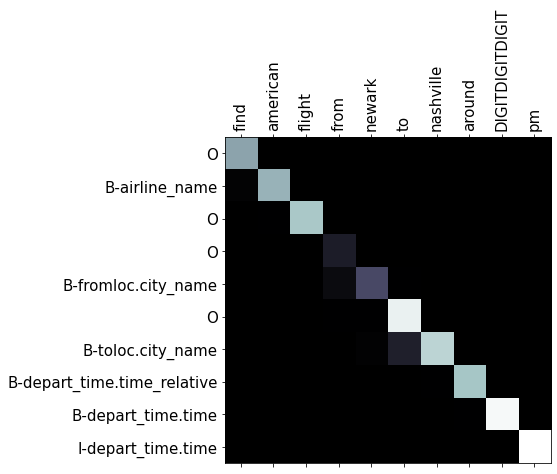



Test sample 386:


,list(0),a(1),flight(2),from(3),toronto(4),to(5),san(6),diego(7)
target,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,I-toloc.city_name
predicted,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,I-toloc.city_name


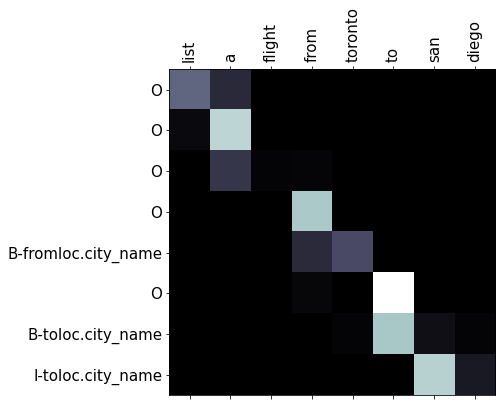



Test sample 462:


,i(0),want(1),to(2),go(3),from(4),boston(5),to(6),washington(7),on(8),a(9),saturday(10)
target,O,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,O,O,B-depart_date.day_name
predicted,O,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,O,O,B-depart_date.day_name


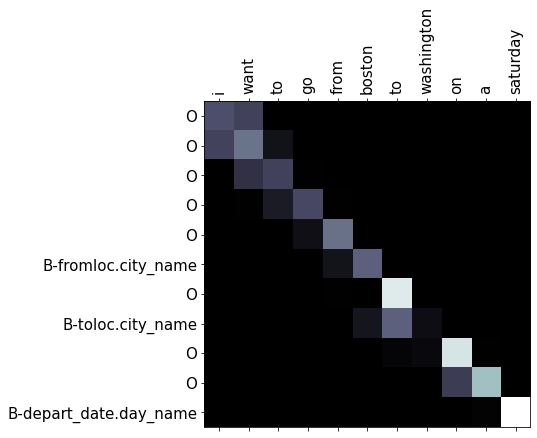

In [32]:
if os.path.exists(f'{PLOTS_PATH}/align_scores'):
  shutil.rmtree(f'{PLOTS_PATH}/align_scores')
os.makedirs(f'{PLOTS_PATH}/align_scores', exist_ok=True)

# Print some samples from test set
test_data = ATISDataset('test', vocab)
model.eval()
samples_idx = np.random.randint(0, len(test_data), 3)

print('Sample predictions and alignment scores from test set\n')
for idx in samples_idx:
  print(f'Test sample {idx}:')
  input, target = test_data[idx]
  input, target = input.to(device), target.to(device)
  output, predicted_labels, attn = model(input.unsqueeze(0))

  # Display result
  input = [vocab.idx2word[w.item()] for w in input]
  target = [vocab.idx2concept[w.item()] for w in target]
  predicted = [vocab.idx2concept[w.item()] for w in predicted_labels[0]]
  df = pd.DataFrame([target, predicted], columns=[f'{w}({i})' for i,w in enumerate(input)], index=['target', 'predicted'])
  display(df.style.apply(lambda s: np.where(s == s[0], '', 'color: red')))

  # Display attention matrix
  if attn is not None:
    attn = attn.squeeze(0).detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(attn, cmap='bone')
    ax.set_xticklabels(['']+input, rotation=90)
    ax.set_yticklabels(['']+predicted)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    plt.savefig(f'{PLOTS_PATH}/align_scores/align_score_{idx}.png', bbox_inches='tight', dpi=200)

  plt.show()
  print('\n')